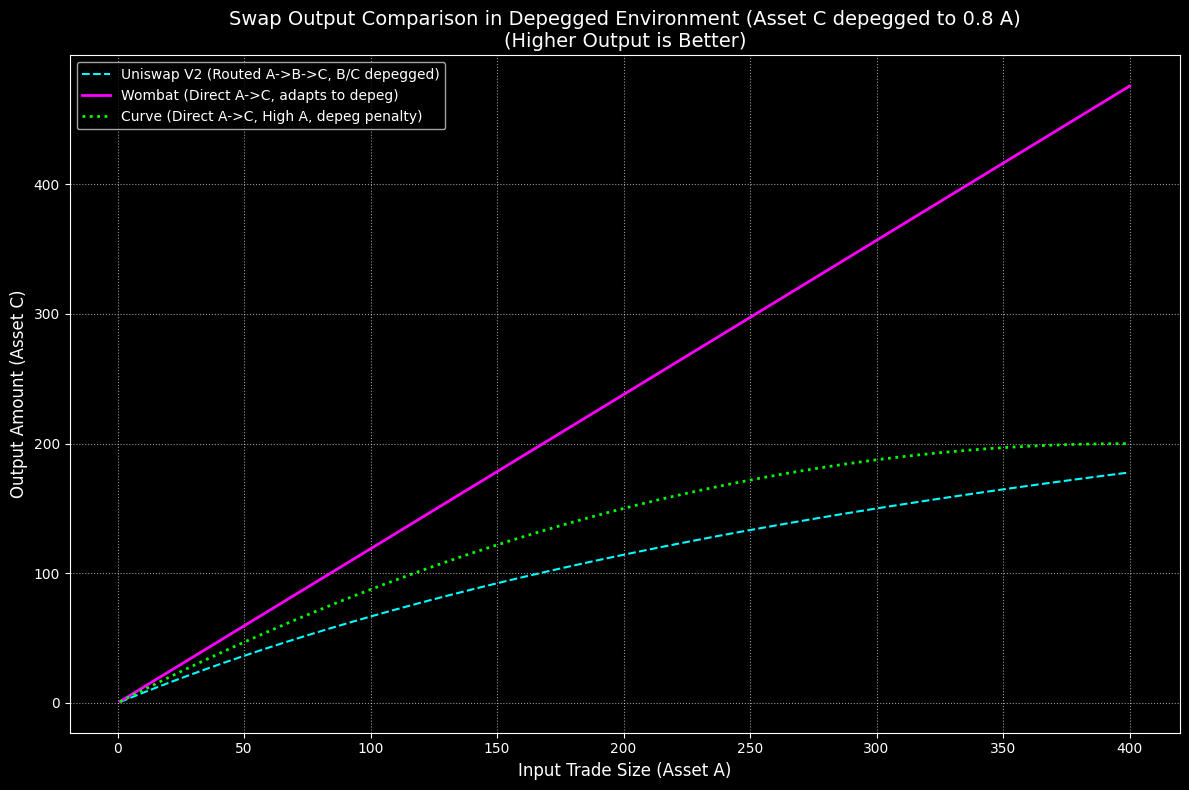

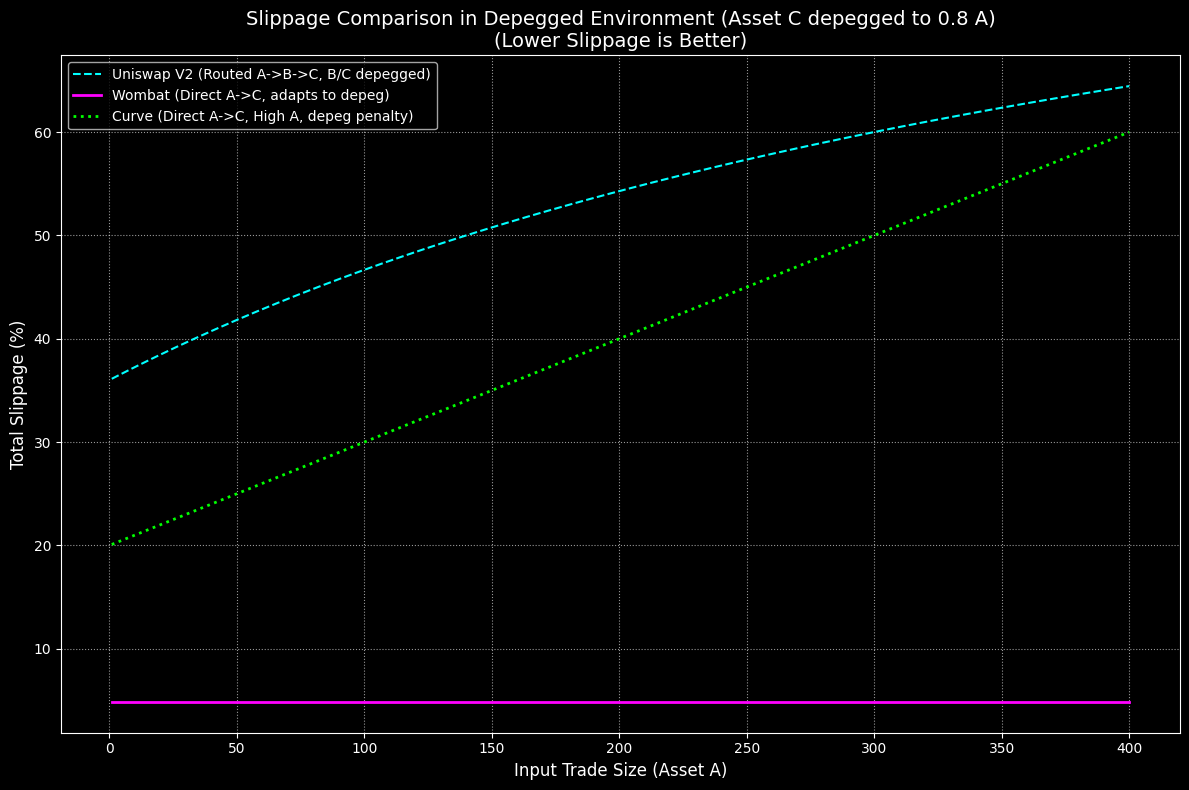

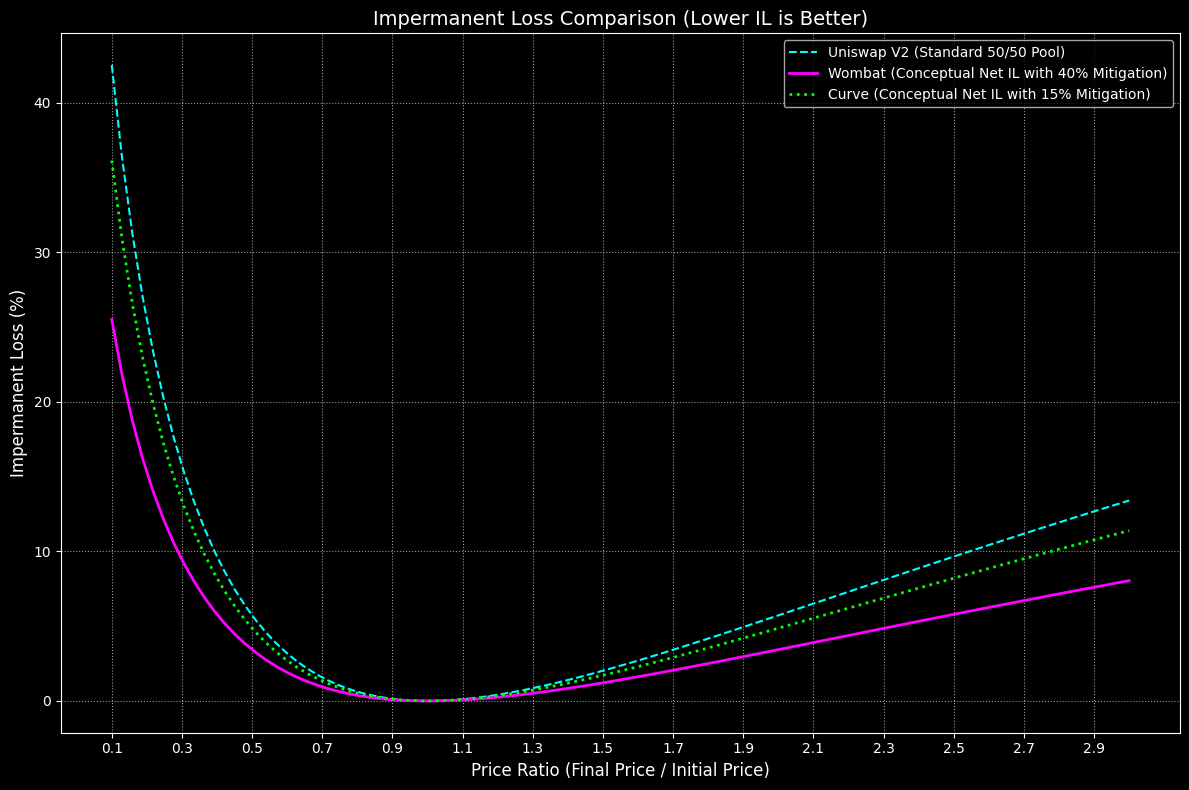

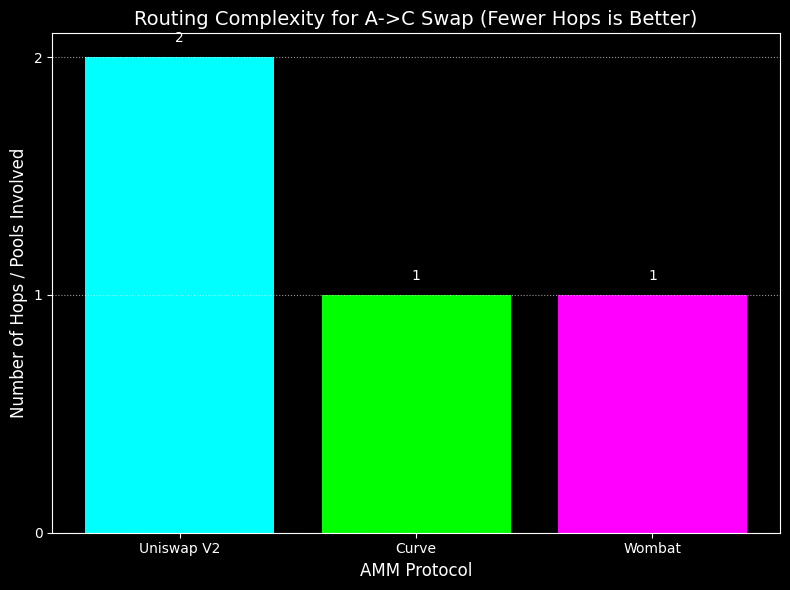

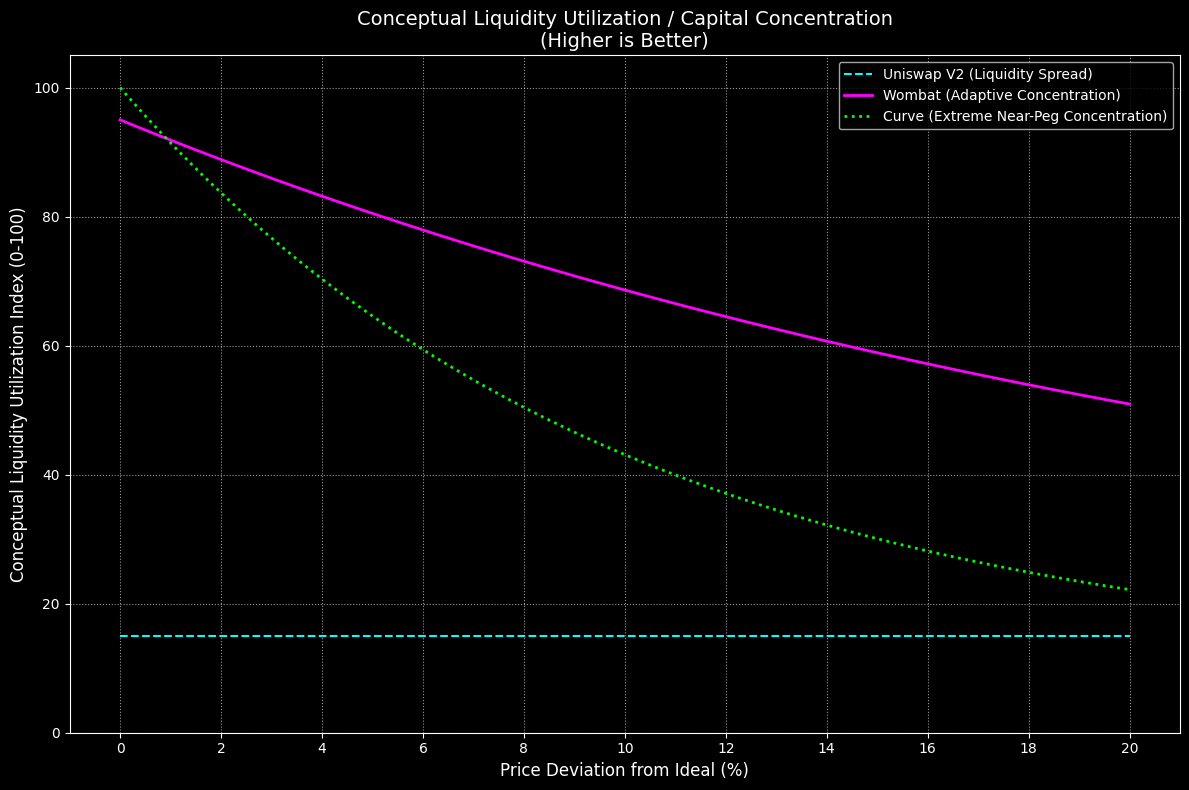

In [4]:
import matplotlib.pyplot as plt
import numpy as np

# --- Uniswap V2 Functions ---
def uniswap_v2_pool(reserve_a, reserve_b):
    """Creates a constant product pool."""
    if reserve_a <= 0 or reserve_b <= 0:
        return {'a': 0, 'b': 0, 'k': 0}
    return {'a': reserve_a, 'b': reserve_b, 'k': reserve_a * reserve_b}

def uniswap_v2_swap(pool, amount_in):
    """Calculates swap output. Returns 0 if pool is empty."""
    if pool['k'] <= 0 or (pool['a'] + amount_in) <= 0:
        return 0, pool
    
    initial_reserves_b = pool['b']
    amount_out = initial_reserves_b - pool['k'] / (pool['a'] + amount_in)
    
    final_pool_a = pool['a'] + amount_in
    final_pool_b = initial_reserves_b - amount_out
    
    return amount_out, uniswap_v2_pool(final_pool_a, final_pool_b)

# --- Wombat Functions ---
def wombat_style_pool(reserves, liabilities, prices, alpha):
    """Creates a simplified Wombat-style pool."""
    return {
        'assets': reserves.copy(),
        'liabilities': liabilities.copy(),
        'prices': prices,
        'alpha': alpha
    }

def wombat_swap(pool, amount_in, token_in, token_out):
    """
    Simulates a swap in a Wombat-style pool, emphasizing its handling of depegged assets.
    """
    r_in = pool['assets'][token_in] / pool['liabilities'][token_in]
    r_out = pool['assets'][token_out] / pool['liabilities'][token_out]
    
    base_price_in = pool['prices'][token_in]
    base_price_out = pool['prices'][token_out]
    
    numerator = base_price_in * (1 + pool['alpha'] / (r_in**2))
    denominator = base_price_out * (1 + pool['alpha'] / (r_out**2))
    
    effective_price = numerator / denominator
    
    amount_out = amount_in * effective_price
    
    if pool['assets'][token_out] - amount_out < 0:
        amount_out = pool['assets'][token_out] * 0.999
        
    pool['assets'][token_in] += amount_in
    pool['assets'][token_out] -= amount_out
    
    return amount_out, pool

# --- Curve Finance Functions ---
def curve_pool(reserves, A):
    """Creates a simplified Curve-style pool."""
    return {
        'reserves': reserves.copy(),
        'A': A
    }

def curve_swap(pool, amount_in, token_in, token_out, depeg_factor=1.0):
    """
    Simulates a swap in a simplified Curve-style pool in a volatile environment.
    """
    initial_reserve_in = pool['reserves'][token_in]
    initial_reserve_out = pool['reserves'][token_out]
    
    fair_output_before_amm_slippage = amount_in * (1 / depeg_factor)
    
    implied_pool_price_ratio = initial_reserve_out / initial_reserve_in 
    internal_deviation = abs(1.0 - implied_pool_price_ratio)
    market_deviation = abs(1.0 - depeg_factor)
    
    depeg_slippage_penalty = (market_deviation + internal_deviation) * pool['A'] * 0.0005
    trade_size_slippage = amount_in / initial_reserve_in
    
    total_slippage_factor = trade_size_slippage + depeg_slippage_penalty
    total_slippage_factor = min(total_slippage_factor, 0.99)
    
    amount_out = fair_output_before_amm_slippage * (1 - total_slippage_factor)
    
    if pool['reserves'][token_out] - amount_out < 0:
        amount_out = pool['reserves'][token_out] * 0.999
        
    pool['reserves'][token_in] += amount_in
    pool['reserves'][token_out] -= amount_out
    
    return amount_out, pool

# --- Main Comparative Simulation (Swap Output & Slippage) ---

def run_comparative_simulation_volatile():
    """
    Runs a simulation comparing Uniswap V2, Wombat, and Curve swaps
    in a highly volatile environment where one asset (C) is depegged.
    Generates two separate plots for swap output and slippage.
    """
    trade_sizes = np.linspace(1, 400, 50)
    
    uniswap_outputs = []
    wombat_outputs = []
    curve_outputs = []
    
    uniswap_slippages = []
    wombat_slippages = []
    curve_slippages = []

    depeg_market_price_ratio_A_to_C = 0.8
    ideal_output_per_unit_A = 1 / depeg_market_price_ratio_A_to_C

    initial_pool_ab = uniswap_v2_pool(1000, 1000)
    initial_pool_bc_depegged = uniswap_v2_pool(1000, 800)

    initial_wombat_pool_reserves = {'a': 1000, 'b': 1000, 'c': 800}
    initial_wombat_pool_liabilities = {'a': 1000, 'b': 1000, 'c': 1000}
    initial_wombat_pool_prices = {'a': 1.0, 'b': 1.0, 'c': depeg_market_price_ratio_A_to_C} 
    initial_wombat_pool = wombat_style_pool(
        initial_wombat_pool_reserves,
        initial_wombat_pool_liabilities,
        initial_wombat_pool_prices,
        alpha=0.1
    )
    
    initial_curve_pool_reserves = {'a': 1000, 'c': 1000}
    initial_curve_pool = curve_pool(initial_curve_pool_reserves, A=2000)

    for size in trade_sizes:
        # Uniswap V2 Routed Swap
        pool_ab = initial_pool_ab.copy()
        pool_bc = initial_pool_bc_depegged.copy()
        
        amount_b_out, _ = uniswap_v2_swap(pool_ab, size)
        final_c_out_uni, _ = uniswap_v2_swap(pool_bc, amount_b_out)
        
        uniswap_outputs.append(final_c_out_uni)
        
        if size > 0:
            ideal_output_for_this_trade = size * ideal_output_per_unit_A
            slippage_uni = ((ideal_output_for_this_trade - final_c_out_uni) / ideal_output_for_this_trade) * 100
            uniswap_slippages.append(max(0, slippage_uni))
        else:
            uniswap_slippages.append(0)

        # Wombat Unified Swap
        wombat_pool = wombat_style_pool(
            initial_wombat_pool_reserves.copy(),
            initial_wombat_pool_liabilities.copy(),
            initial_wombat_pool_prices.copy(),
            alpha=initial_wombat_pool['alpha']
        )
        final_c_out_wombat, _ = wombat_swap(wombat_pool, size, 'a', 'c')
        wombat_outputs.append(final_c_out_wombat)
        
        if size > 0:
            ideal_output_for_this_trade = size * ideal_output_per_unit_A
            slippage_wombat = ((ideal_output_for_this_trade - final_c_out_wombat) / ideal_output_for_this_trade) * 100
            wombat_slippages.append(max(0, slippage_wombat))
        else:
            wombat_slippages.append(0)
            
        # Curve Unified Swap
        curve_pool_current = curve_pool(initial_curve_pool_reserves.copy(), A=initial_curve_pool['A'])
        final_c_out_curve, _ = curve_swap(curve_pool_current, size, 'a', 'c', depeg_factor=depeg_market_price_ratio_A_to_C)
        curve_outputs.append(final_c_out_curve)

        if size > 0:
            ideal_output_for_this_trade = size * ideal_output_per_unit_A
            slippage_curve = ((ideal_output_for_this_trade - final_c_out_curve) / ideal_output_for_this_trade) * 100
            slippage_curve = min(slippage_curve, 1000) # Cap extreme slippage for plotting clarity
            curve_slippages.append(max(0, slippage_curve))
        else:
            curve_slippages.append(0)

    plt.style.use('dark_background')

    # Plot 1: Final Output vs. Trade Size
    plt.figure(figsize=(12, 8))
    plt.plot(trade_sizes, uniswap_outputs, label='Uniswap V2 (Routed A->B->C, B/C depegged)', color='cyan', linestyle='--')
    plt.plot(trade_sizes, wombat_outputs, label='Wombat (Direct A->C, adapts to depeg)', color='magenta', linewidth=2)
    plt.plot(trade_sizes, curve_outputs, label='Curve (Direct A->C, High A, depeg penalty)', color='lime', linewidth=2, linestyle=':')
    plt.title(f'Swap Output Comparison in Depegged Environment (Asset C depegged to {depeg_market_price_ratio_A_to_C} A)\n(Higher Output is Better)', fontsize=14)
    plt.xlabel('Input Trade Size (Asset A)', fontsize=12)
    plt.ylabel('Output Amount (Asset C)', fontsize=12)
    plt.legend()
    plt.grid(True, linestyle=':', alpha=0.6)
    plt.tight_layout()
    plt.savefig("swap_output_depegged_environment.png")
    plt.show()

    # Plot 2: Slippage vs. Trade Size
    plt.figure(figsize=(12, 8))
    plt.plot(trade_sizes, uniswap_slippages, label='Uniswap V2 (Routed A->B->C, B/C depegged)', color='cyan', linestyle='--')
    plt.plot(trade_sizes, wombat_slippages, label='Wombat (Direct A->C, adapts to depeg)', color='magenta', linewidth=2)
    plt.plot(trade_sizes, curve_slippages, label='Curve (Direct A->C, High A, depeg penalty)', color='lime', linewidth=2, linestyle=':')
    plt.title(f'Slippage Comparison in Depegged Environment (Asset C depegged to {depeg_market_price_ratio_A_to_C} A)\n(Lower Slippage is Better)', fontsize=14)
    plt.xlabel('Input Trade Size (Asset A)', fontsize=12)
    plt.ylabel('Total Slippage (%)', fontsize=12)
    plt.legend()
    plt.grid(True, linestyle=':', alpha=0.6)
    plt.tight_layout()
    plt.savefig("slippage_depegged_environment.png")
    plt.show()

# --- Impermanent Loss Simulation ---

def calculate_uniswap_v2_il_percentage(price_ratio):
    """Calculates theoretical IL for a 50/50 Uniswap V2 pool in percentage."""
    if price_ratio <= 0:
        return np.inf

    il_decimal = (2 * np.sqrt(price_ratio) / (1 + price_ratio)) - 1
    return abs(il_decimal) * 100

def run_impermanent_loss_simulation():
    """
    Simulates and plots Impermanent Loss for Uniswap V2, Wombat, and Curve.
    """
    price_ratios = np.linspace(0.1, 3.0, 100) 

    uniswap_ils = []
    wombat_conceptual_ils = []
    curve_conceptual_ils = []

    total_wombat_mitigation_factor = 0.40 
    curve_mitigation_factor = 0.15 

    for pr in price_ratios:
        uni_il = calculate_uniswap_v2_il_percentage(pr)
        uniswap_ils.append(uni_il)

        wombat_il = uni_il * (1 - total_wombat_mitigation_factor)
        wombat_conceptual_ils.append(max(0, wombat_il))

        curve_il = uni_il * (1 - curve_mitigation_factor)
        curve_conceptual_ils.append(max(0, curve_il))

    plt.style.use('dark_background')
    plt.figure(figsize=(12, 8))
    
    plt.plot(price_ratios, uniswap_ils, label='Uniswap V2 (Standard 50/50 Pool)', color='cyan', linestyle='--')
    plt.plot(price_ratios, wombat_conceptual_ils, label=f'Wombat (Conceptual Net IL with {total_wombat_mitigation_factor*100:.0f}% Mitigation)', color='magenta', linewidth=2)
    plt.plot(price_ratios, curve_conceptual_ils, label=f'Curve (Conceptual Net IL with {curve_mitigation_factor*100:.0f}% Mitigation)', color='lime', linewidth=2, linestyle=':')

    plt.title('Impermanent Loss Comparison (Lower IL is Better)', fontsize=14)
    plt.xlabel('Price Ratio (Final Price / Initial Price)', fontsize=12)
    plt.ylabel('Impermanent Loss (%)', fontsize=12)
    plt.xticks(np.arange(0.1, 3.1, 0.2))
    plt.grid(True, linestyle=':', alpha=0.6)
    plt.legend()
    plt.tight_layout()
    plt.savefig("impermanent_loss_comparison.png")
    plt.show()

# --- NEW: Routing Complexity Simulation ---
def run_routing_complexity_simulation():
    """
    Simulates and plots Routing Complexity as number of hops.
    """
    protocols = ['Uniswap V2', 'Curve', 'Wombat']
    # For A->C swap, Uniswap V2 often needs A->B->C (2 hops) due to fragmentation.
    # Curve (for multi-stable or multi-volatile pool) and Wombat (single pool) are direct.
    num_hops = [2, 1, 1] 

    plt.style.use('dark_background')
    plt.figure(figsize=(8, 6))
    
    bars = plt.bar(protocols, num_hops, color=['cyan', 'lime', 'magenta'])
    
    plt.title('Routing Complexity for A->C Swap (Fewer Hops is Better)', fontsize=14)
    plt.xlabel('AMM Protocol', fontsize=12)
    plt.ylabel('Number of Hops / Pools Involved', fontsize=12)
    plt.yticks(np.arange(0, 3, 1)) # Only integer hops
    plt.grid(axis='y', linestyle=':', alpha=0.6)
    
    # Add values on top of bars
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval + 0.05, int(yval), ha='center', va='bottom', color='white', fontsize=10)

    plt.tight_layout()
    plt.savefig("routing_complexity.png")
    plt.show()


# --- NEW: Liquidity Utilization Simulation ---
def run_liquidity_utilization_simulation():
    """
    Simulates and plots conceptual Liquidity Utilization / Capital Concentration.
    This illustrates how much of the total deployed capital is effectively
    contributing to low slippage at various price deviations from the peg.
    """
    # Price deviation from the current market price (e.g., how far from 1:1 or current spot)
    price_deviations_percent = np.linspace(0, 20, 100) # 0% to 20% deviation

    # Conceptual utilization scores (Higher is better)
    # Uniswap V2: Low and flat, as liquidity is spread infinitely.
    uniswap_utilization = np.full_like(price_deviations_percent, 15) 

    # Curve: Very high near 0% deviation (near peg), drops very sharply.
    curve_utilization = 90 * np.exp(-10 * price_deviations_percent / 100) + 10 
    
    # Wombat: High, drops more gracefully than Curve, reflecting adaptive concentration.
    wombat_utilization = 80 * np.exp(-4 * price_deviations_percent / 100) + 15

    plt.style.use('dark_background')
    plt.figure(figsize=(12, 8))
    
    plt.plot(price_deviations_percent, uniswap_utilization, label='Uniswap V2 (Liquidity Spread)', color='cyan', linestyle='--')
    plt.plot(price_deviations_percent, wombat_utilization, label='Wombat (Adaptive Concentration)', color='magenta', linewidth=2)
    plt.plot(price_deviations_percent, curve_utilization, label='Curve (Extreme Near-Peg Concentration)', color='lime', linewidth=2, linestyle=':')

    plt.title('Conceptual Liquidity Utilization / Capital Concentration\n(Higher is Better)', fontsize=14)
    plt.xlabel('Price Deviation from Ideal (%)', fontsize=12)
    plt.ylabel('Conceptual Liquidity Utilization Index (0-100)', fontsize=12)
    plt.xticks(np.arange(0, 21, 2))
    plt.ylim(0, 105)
    plt.grid(True, linestyle=':', alpha=0.6)
    plt.legend()
    plt.tight_layout()
    plt.savefig("liquidity_utilization.png")
    plt.show()


# --- Run All Simulations ---
run_comparative_simulation_volatile()
run_impermanent_loss_simulation()
run_routing_complexity_simulation()
run_liquidity_utilization_simulation()

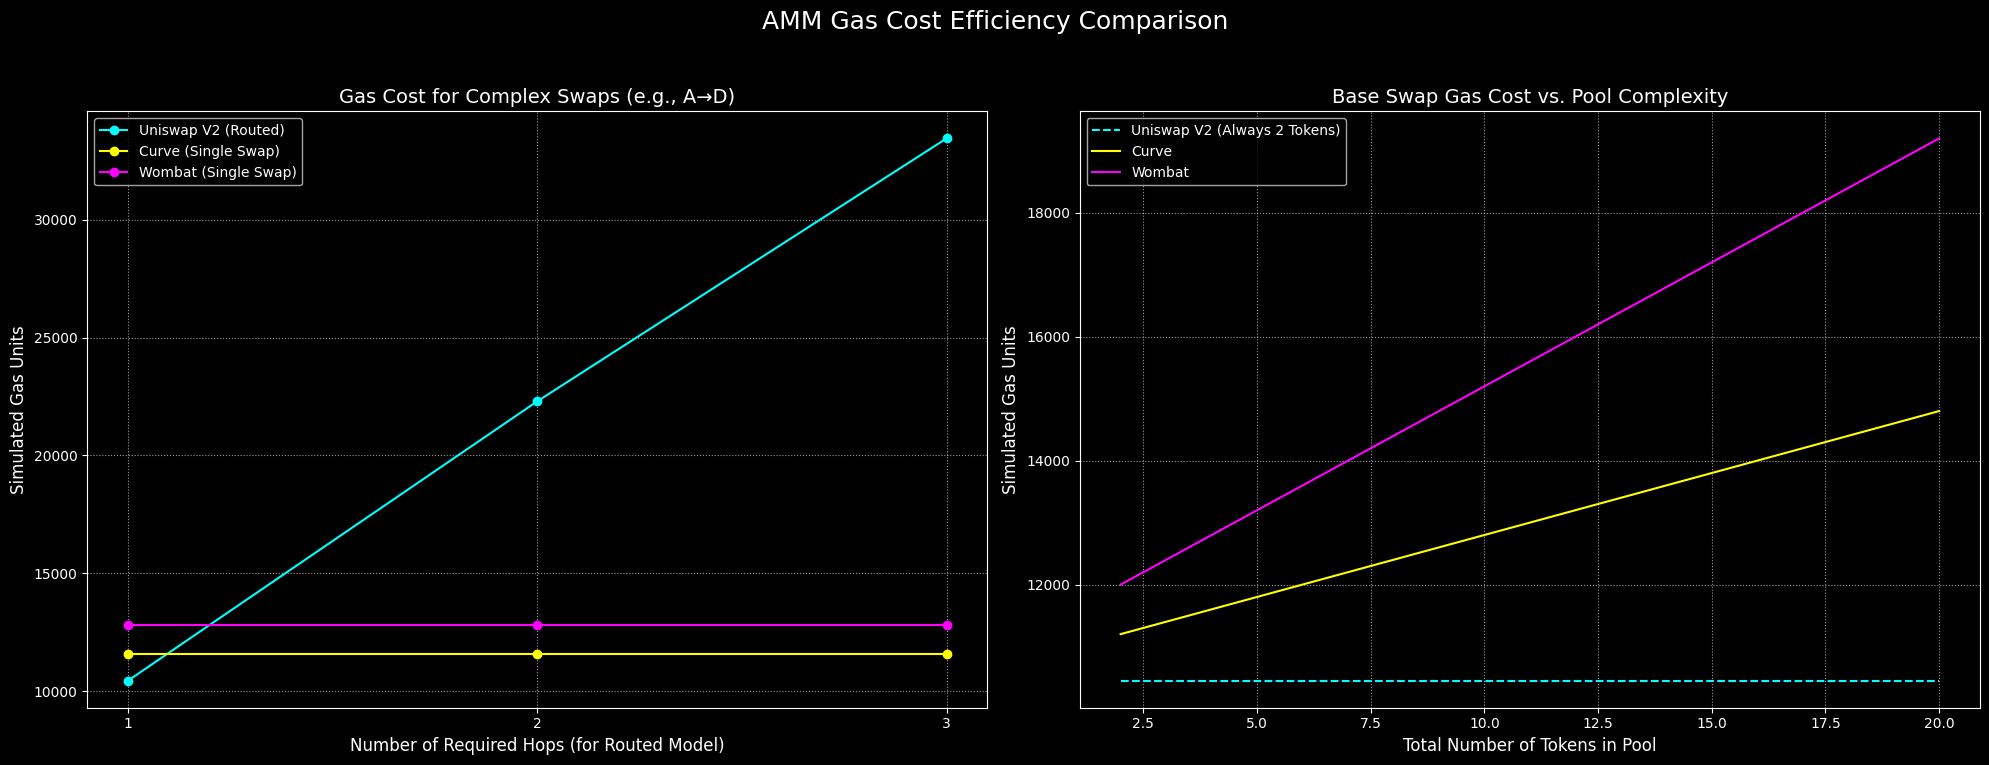

In [2]:
import matplotlib.pyplot as plt
import numpy as np

# --- Synthetic Gas Cost Constants ---
C_SLOAD = 200
C_SSTORE = 5000
C_CALL = 700
C_MATH_SIMPLE = 50
C_MATH_WOMBAT_DIRECT = 250
C_MATH_SQRT = 150
C_MATH_ITER_BASE = 800 # Base cost for Curve's loop

# --- Gas Simulation Functions ---

def simulate_gas_uniswap_v2(num_hops):
    """Calculates gas for a Uniswap V2 swap path."""
    single_swap_cost = 2 * C_SLOAD + 2 * C_SSTORE + C_MATH_SIMPLE
    if num_hops == 1:
        return single_swap_cost
    # Multi-hop cost includes call overhead for each hop
    return num_hops * (single_swap_cost + C_CALL)

def simulate_gas_curve(num_tokens_in_pool, imbalance_factor=1.0):
    """Simulates gas for a Curve swap."""
    # Iteration cost can increase with imbalance
    iter_cost = C_MATH_ITER_BASE * imbalance_factor
    read_cost = num_tokens_in_pool * C_SLOAD
    write_cost = 2 * C_SSTORE
    return read_cost + write_cost + iter_cost

def simulate_gas_wombat(num_tokens_in_pool):
    """Simulates gas for a Wombat swap, including health check."""
    # Fixed cost for the 2-token swap logic
    base_swap_cost = 4 * C_SLOAD + 2 * C_SSTORE + C_MATH_WOMBAT_DIRECT
    # Variable cost for health check, scales with total tokens in pool
    health_check_cost = num_tokens_in_pool * (2 * C_SLOAD) + C_MATH_SQRT
    return base_swap_cost + health_check_cost

# --- Main Plotting Logic ---

def generate_gas_comparison_plots():
    plt.style.use('dark_background')
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
    fig.suptitle('AMM Gas Cost Efficiency Comparison', fontsize=18)

    # Plot 1: Gas Cost vs. Number of Hops (for an A -> D trade)
    hops = np.arange(1, 4) # Simulating 1, 2, 3 hops
    
    # Uniswap V2: Cost scales with hops
    uniswap_costs = [simulate_gas_uniswap_v2(h) for h in hops]
    
    # Wombat & Curve: Cost is flat as it's a single operation in a 4-token pool
    wombat_cost_4_token_pool = simulate_gas_wombat(num_tokens_in_pool=4)
    wombat_costs = [wombat_cost_4_token_pool] * len(hops)
    curve_cost_4_token_pool = simulate_gas_curve(num_tokens_in_pool=4)
    curve_costs_plot1 = [curve_cost_4_token_pool] * len(hops)


    ax1.plot(hops, uniswap_costs, 'o-', label='Uniswap V2 (Routed)', color='cyan')
    ax1.plot(hops, curve_costs_plot1, 'o-', label='Curve (Single Swap)', color='yellow')
    ax1.plot(hops, wombat_costs, 'o-', label='Wombat (Single Swap)', color='magenta')
    ax1.set_title('Gas Cost for Complex Swaps (e.g., A→D)', fontsize=14)
    ax1.set_xlabel('Number of Required Hops (for Routed Model)', fontsize=12)
    ax1.set_ylabel('Simulated Gas Units', fontsize=12)
    ax1.set_xticks(hops)
    ax1.legend()
    ax1.grid(True, linestyle=':', alpha=0.6)

    # Plot 2: Gas Cost vs. Number of Tokens in Pool (for a single swap)
    pool_sizes = np.arange(2, 21)
    uniswap_single_cost = [simulate_gas_uniswap_v2(num_hops=1)] * len(pool_sizes)
    curve_costs_plot2 = [simulate_gas_curve(n) for n in pool_sizes]
    wombat_costs_by_size = [simulate_gas_wombat(n) for n in pool_sizes]

    ax2.plot(pool_sizes, uniswap_single_cost, label='Uniswap V2 (Always 2 Tokens)', color='cyan', linestyle='--')
    ax2.plot(pool_sizes, curve_costs_plot2, label='Curve', color='yellow')
    ax2.plot(pool_sizes, wombat_costs_by_size, label='Wombat', color='magenta')
    ax2.set_title('Base Swap Gas Cost vs. Pool Complexity', fontsize=14)
    ax2.set_xlabel('Total Number of Tokens in Pool', fontsize=12)
    ax2.set_ylabel('Simulated Gas Units', fontsize=12)
    ax2.legend()
    ax2.grid(True, linestyle=':', alpha=0.6)
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.savefig("amm_gas_comparison_with_curve.png")
    plt.show()

# Run the plotting function
generate_gas_comparison_plots()

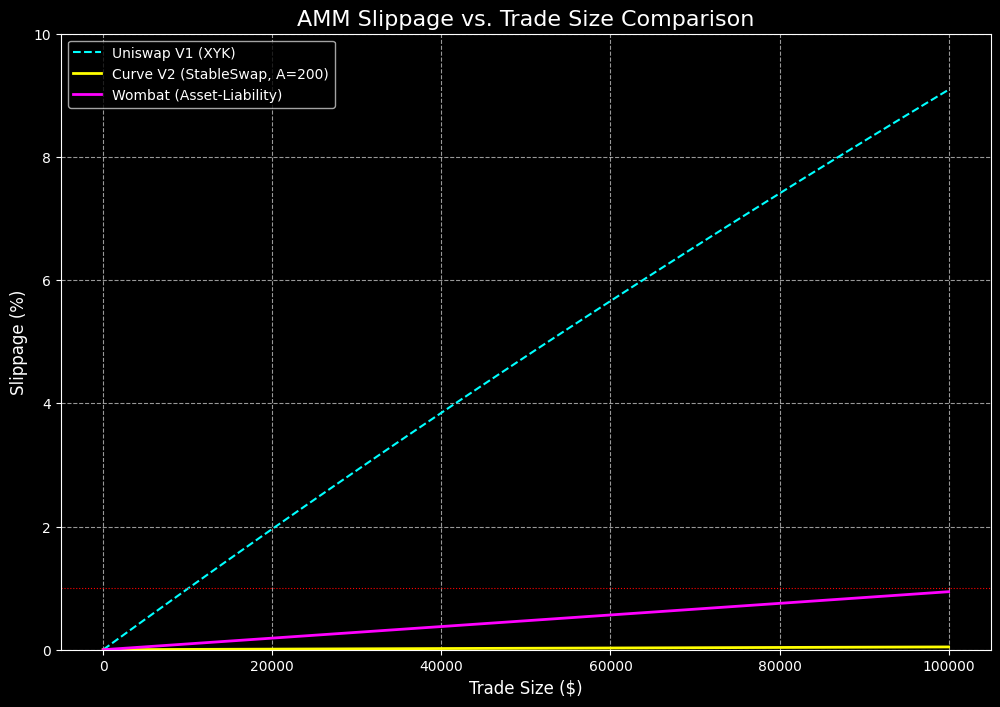

In [4]:
import numpy as np
import matplotlib.pyplot as plt

#--- Protocol Simulation Functions ---

def simulate_uniswap_v1_slippage(trade_size, reserve_x=1000000, reserve_y=1000000):
    """Calculates slippage for a Uniswap V1 trade.
    Assumes a fixed 50/50 pool based on the constant product formula.
    This model represents lower capital efficiency as liquidity is spread infinitely.
    """
    k = reserve_x * reserve_y
    initial_price = reserve_y / reserve_x
    amount_out = reserve_y - k / (reserve_x + trade_size)

    if trade_size == 0: return 0

    effective_price = amount_out / trade_size
    slippage = abs(initial_price - effective_price) / initial_price
    return slippage * 100

def simulate_curve_slippage(trade_size, reserve_x=1000000, reserve_y=1000000, A=100):
    """A simplified conceptual simulation of Curve V2's slippage (StableSwap).
    A true implementation requires a numerical solver for the StableSwap invariant.
    This model uses a heuristic blend of constant sum and constant product
    based on the amplification factor 'A' for visualization purposes,
    representing high capital efficiency for pegged assets due to liquidity concentration.
    """
    # Constant sum part (ideal for pegged assets, very high capital efficiency)
    price_cs = 1.0
    amount_out_cs = trade_size * price_cs

    # Constant product part (like Uniswap V1 for de-pegged portions, lower capital efficiency)
    k = reserve_x * reserve_y
    initial_price_cp = reserve_y / reserve_x
    amount_out_cp = reserve_y - k / (reserve_x + trade_size)

    # Blend based on amplification factor A. Higher A leans towards constant sum.
    # This weight factor is heuristic for visualization purposes.
    weight = A / (A + 1)
    amount_out = (amount_out_cs * weight) + (amount_out_cp * (1 - weight))

    if trade_size == 0: return 0

    effective_price = amount_out / trade_size
    # Assuming initial peg of 1.0 for simplicity in slippage calculation
    slippage = abs(1.0 - effective_price) / 1.0
    return slippage * 100

def simulate_wombat_slippage(trade_size, asset_x=1000000, liab_x=1000000, 
                             asset_y=1000000, liab_y=1000000, 
                             p_scale_x=1.0, p_scale_y=1.0, alpha=0.05):
    """Simulates slippage based on Wombat's spot price formula.
    Simulates the trade in small steps to see how the coverage ratio changes.
    This model aims to show high capital efficiency through dynamic repegging and unified liquidity.
    """
    steps = 100
    step_size = trade_size / steps
    total_amount_out = 0.0

    temp_asset_x = float(asset_x)
    temp_asset_y = float(asset_y)

    for _ in range(steps):
        r_x = temp_asset_x / liab_x
        r_y = temp_asset_y / liab_y

        # Wombat's spot price formula (inverse of what's in paper, for A_x -> A_y swap)
        # Price of X in terms of Y = (P_x_scaled * (1 + alpha/r_x^2)) / (P_y_scaled * (1 + alpha/r_y^2))
        numerator = p_scale_y * (1 + alpha / (r_y**2))
        denominator = p_scale_x * (1 + alpha / (r_x**2))
        
        # This is the price of adding X and getting Y out (dX/dY)
        spot_price_reciprocal = numerator / denominator 
        
        # So amount_out_step = amount_in_step / spot_price_reciprocal
        amount_out_step = step_size / spot_price_reciprocal # Amount of Y received for dx of X
        
        total_amount_out += amount_out_step

        # Update assets for next step
        temp_asset_x += step_size
        temp_asset_y -= amount_out_step

    if trade_size == 0: return 0

    effective_price = total_amount_out / trade_size
    initial_price = p_scale_y / p_scale_x # Assuming ideal initial price for the pair
    slippage = abs(initial_price - effective_price) / initial_price
    return slippage * 100

#--- Charting Logic ---

def generate_slippage_comparison_chart():
    """Generates the logic to plot slippage vs. trade size."""

    liquidity = 1000000  # Assume $1M of each asset in the pools for initial state
    trade_sizes = np.linspace(0, 100000, 100)  # Trades from $0 to $100k

    # Calculate slippage for each protocol
    slippage_v1 = [simulate_uniswap_v1_slippage(s, liquidity, liquidity) for s in trade_sizes]
    slippage_curve = [simulate_curve_slippage(s, liquidity, liquidity, A=200) for s in trade_sizes]
    slippage_wombat = [simulate_wombat_slippage(s, liquidity, liquidity, liquidity, liquidity) for s in trade_sizes]

    # Plotting Code ---
    plt.style.use('dark_background')
    plt.figure(figsize=(12, 8))

    plt.plot(trade_sizes, slippage_v1, label='Uniswap V1 (XYK)', color='cyan', linestyle='--')
    plt.plot(trade_sizes, slippage_curve, label='Curve V2 (StableSwap, A=200)', color='yellow', linewidth=2)
    plt.plot(trade_sizes, slippage_wombat, label='Wombat (Asset-Liability)', color='magenta', linewidth=2)

    plt.title('AMM Slippage vs. Trade Size Comparison', fontsize=16)
    plt.xlabel('Trade Size ($)', fontsize=12)
    plt.ylabel('Slippage (%)', fontsize=12)
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.ylim(0, 10)  # Cap y-axis for better readability
    plt.axhline(y=1, color='red', linestyle=':', linewidth=0.8, label='1% Slippage Threshold')

    # To run this code, you would typically call plt.show() or plt.savefig() here.
    # For example:
    plt.savefig("slippage_comparison.png")
    plt.show()

# Example of how to call the chart generation
generate_slippage_comparison_chart()